In [1]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns
import matplotlib
import pandas as pd

import matplotlib

from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.transform import rotate, SimilarityTransform, warp
from skimage.measure import regionprops

import patato as pat
from patato.useful_utilities import add_axis_label, add_subfigure_label

from PIL import Image

import scienceplots

plt.style.use(["science", "nature", "no-latex"])

matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["figure.constrained_layout.use"] = True

In [2]:
def rotate_image(im, theta, ax=None, scale=1):
    x = im.get_array().copy()
    rows, cols = x.shape
    assert rows == cols

    theta = theta * np.pi / 180

    # Translate the image
    props = regionprops((~np.isnan(x)).astype(np.uint8))
    prop = max(props, key=lambda x: x.area)
    rowc, colc = prop.centroid

    # rotation around center
    blob_center = np.array((colc, rowc)) - 0.5
    center = np.array((cols, rows)) / 2 - 0.5

    tform1 = SimilarityTransform(translation=blob_center)
    tform2 = SimilarityTransform(rotation=theta)
    tform3 = SimilarityTransform(translation=-center)
    tform = tform3 + tform2 + tform1

    d = warp(x, tform, cval=np.nan)
    im.set_data(d)

    # for scale, we'll just adjust the axis limits.
    if scale != 1:
        if ax is None:
            raise ValueError(
                "For rescaling, axes must be passed as a keyword argument."
            )
        else:
            a, b = ax.get_xlim()
            ax.set_xlim(a / scale, b / scale)
            a, b = ax.get_ylim()
            ax.set_ylim(a / scale, b / scale)
    return im

In [3]:
def fix_clims(ims, lower=None, upper=None):
    min_c = np.inf
    max_c = -np.inf
    for i in ims:
        a, b = i.get_clim()
        if min_c > a:
            min_c = a
        if max_c < b:
            max_c = b
    if lower is not None:
        min_c = lower
    if upper is not None:
        max_c = upper
    for i in ims:
        i.set_clim((min_c, max_c))

In [4]:
df = pd.read_pickle("../data/phantoms/intermediate results/flow_spectrum_invision.pd")

In [5]:
cmap = matplotlib.colormaps["plasma"]

labels = ["low_melanin", "medium_melanin", "high_melanin"]
colours = {
    "low_melanin": cmap(1.0),
    "medium_melanin": cmap(0.5),
    "high_melanin": cmap(0.0),
    "Base_phantom": "r",
}

concentrations = [0.0, 0.1, 0.21]
concentration = {
    "low_melanin": concentrations[0],
    "medium_melanin": concentrations[1],
    "high_melanin": concentrations[2],
}

df["melanin_index"] = df["melanin"].apply(lambda x: concentration.get(x, 1))

In [6]:
image_datasets = [
    pat.PAData.from_hdf5(f"../data/phantoms/Processed_data/{x}.hdf5")
    for x in ["Scan_11", "Scan_7", "Scan_5"]
]

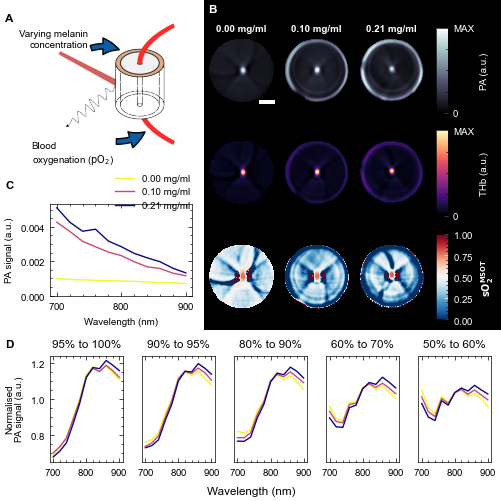

In [8]:
def get_spectra(x):
    # x = x
    # mask = x[0] > np.percentile(x[0], 90)
    # x = x.T[mask.T].T
    return np.mean(x, axis=1)


# Calculate the high-ox measurements:


oxygenation_bands = [(50, 60), (60, 70), (80, 90), (90, 95), (95, 100)][::-1]

fig = plt.figure(figsize=(5, 5))

subfigb, subfiga = fig.subfigures(2, height_ratios=(4, 2))

# Plot images
subfigc, subfigd = subfigb.subfigures(1, 2, width_ratios=(2, 3))

subfigd.set_facecolor("k")

im_grid = subfigd.subplots(3, 3, sharex=True, sharey=True).flatten()
recs = []
thbs = []
so2s = []

for i in range(len(im_grid)):
    dataset = image_datasets[i % 3][0:1]
    dataset.set_default_recon()
    roi = dataset.get_rois()["unnamed_", "0"]
    mask = dataset.get_rois(get_rim_cores=["phantom_"], rim_core_distance=-0.0005)  #
    mask = mask["phantom.core_", "0"]
    if i // 3 == 0:
        im = dataset.get_scan_reconstructions().imshow(
            ax=im_grid[i],
            roi_mask=mask,
            scale_kwargs={
                "fixed_value": 0.005,
                "scale_loc": "none",
                "width_fraction": 0.05,
                "pad": 0,
                "border_pad": 0,
            }
            if i == 0
            else {},
            scalebar=i == 0,
        )
        rotate_image(im, 0, im_grid[i], 1.02)
        recs.append(im)
        if i % 3 == 0:
            cbar_pa = plt.colorbar(im, ax=im_grid[i : i + 3], aspect=7)
            cbar_pa.ax.tick_params(color="w", labelcolor="w")
    elif i // 3 == 1:
        im = dataset.get_scan_thb().imshow(ax=im_grid[i], roi_mask=mask, scalebar=False)
        rotate_image(im, 0, im_grid[i], 1.02)
        thbs.append(im)
        if i % 3 == 0:
            cbar_thb = plt.colorbar(im, ax=im_grid[i : i + 3], aspect=7)
            cbar_thb.ax.tick_params(color="w", labelcolor="w")
    else:
        im = dataset.get_scan_so2().imshow(
            ax=im_grid[i], roi_mask=mask, clim=(0, 1), scalebar=False
        )
        rotate_image(im, 0, im_grid[i], 1.02)
        so2s.append(im)
        if i % 3 == 0:
            cbar_so2 = plt.colorbar(im, ax=im_grid[i : i + 3], aspect=7)
            cbar_so2.ax.tick_params(color="w", labelcolor="w")

fix_clims(recs, 0)
fix_clims(thbs, 0)
fix_clims(so2s, 0, 1)

cbar_pa.ax.set_yticks([0, recs[0].get_clim()[1]], [0, "MAX"])
cbar_thb.ax.set_yticks([0, thbs[0].get_clim()[1]], [0, "MAX"])

cbar_pa.set_label("PA (a.u.)", color="w")
cbar_thb.set_label("THb (a.u.)", color="w")
cbar_so2.set_label("$\mathbf{sO_2^{MSOT}}$", color="w")

for i, label_ax in enumerate(im_grid[:3]):
    label_ax.annotate(
        f"{concentrations[i]:.2f} mg/ml",
        xy=(0.5, 1.05),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize="medium",
        color="w",
        fontweight="bold",
    )


# Plot spectra
axes = subfiga.subplots(1, len(oxygenation_bands))

for (conc, n), gr in df.groupby(["melanin_index", "melanin"], sort=True):
    if n == "Base_phantom":  # Base_phantom is from a separate batch
        continue
    for (a, b), ax in zip(oxygenation_bands, axes):
        high_ox = gr["oxygenation"] > a
        high_ox &= gr["oxygenation"] < b
        spectrum = np.mean(gr["spectrum"].apply(get_spectra)[high_ox])
        ax.plot(
            gr["wavelengths"].iloc[0],
            spectrum / np.mean(spectrum),
            label=f"{conc:.2f} mg/ml",
            c=colours[n],
        )
        ax.sharey(axes[0])
        ax.set_title(f"{a:.0f}% to {b:.0f}%")
for ax in axes[1:]:
    ax.yaxis.set_visible(False)

axes[0].set_ylabel("Normalised\nPA signal (a.u.)")
subfiga.supxlabel("Wavelength (nm)")
# subfiga.suptitle("Blood oxygenation")

# Left hand side:
ax1, ax_null, ax2 = subfigc.subplots(3, height_ratios=(1.75, 0.25, 1))
ax_null.axis("off")

im = Image.open("phantom_diagram.png")
ax1.imshow(im)
ax1.axis("off")

an = ax1.annotate(
    "Varying melanin\nconcentration",
    (291, 153),
    (160, 150),
    va="bottom",
    ha="right",
    fontsize="medium",
    arrowprops=dict(connectionstyle="arc3,rad=-0.2"),
)
an.set_in_layout(False)
an = ax1.annotate(
    "Blood\noxygenation ($\mathrm{pO_2}$)",
    (400, 500),
    (-80, 540),
    va="top",
    ha="left",
    fontsize="medium",
    arrowprops=dict(connectionstyle="arc3,rad=0.2"),
)
an.set_in_layout(False)


# Plot the melanin signal:

spectra = []
wavelengths = image_datasets[0].get_wavelengths()[2:13]
for i in range(3):
    dataset = image_datasets[i][0:1]
    dataset.set_default_recon()

    roi_rim = dataset.get_rois(get_rim_cores=["phantom_"], rim_core_distance=0.001)[
        "phantom.rim_", "0"
    ]

    rec = dataset.get_scan_reconstructions()
    mask, data_slice = roi_rim.to_mask_slice(rec)

    spectrum = np.squeeze(rec.raw_data.T[mask.T].T)[2:13]
    spectra.append(np.mean(spectrum, axis=1))
max_spec = 1e5  # Divide photoacoustic spectra through by 10^5 to put them in a more useful range.

for i in range(3):
    ax2.plot(wavelengths, spectra[i] / max_spec, color=colours[labels[i]])
ax2.set_ylim([0, None])
ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel("PA signal (a.u.)")

# Legend for the spectra
subfigc.legend(
    *axes[0].get_legend_handles_labels(),
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1, 0.5),
)

# Left top

ls = add_axis_label(ax1, "A")
ls = add_subfigure_label(subfigd, im_grid[0], "B")
ls.set_color("white")
ls = add_axis_label(ax2, "C", manual_y=0.2)
ls = add_axis_label(axes[0], "D")

plt.savefig("../figures/invision_phantom.png", dpi=300)
plt.savefig("../figures/invision_phantom.pdf", dpi=300)
plt.show()

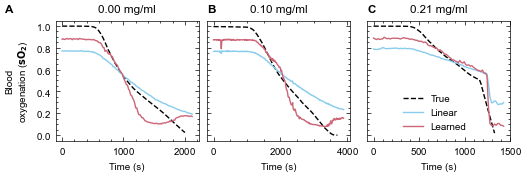

In [9]:
from palettable.cartocolors.qualitative import Safe_2

fig, axes = plt.subplots(1, 3, figsize=(5.25, 5.25 / 3), sharey=True)

i = 0
for (conc, n), gr in df.groupby(["melanin_index", "melanin"], sort=True):
    if n == "Base_phantom":  # Base_phantom is from a separate batch
        continue
    so2 = gr["unmixed_so2"].apply(np.nanmean) * 100
    # Plot the oxygenation dependence.
    axes[i].plot(
        gr["time"] - np.min(gr["time"]),
        gr["oxygenation"] / 100,
        label=f"True",
        linestyle="--",
        color="k",
    )
    axes[i].plot(
        gr["time"] - np.min(gr["time"]),
        gr["unmixed_so2"].apply(np.nanmean),
        label=f"Linear",
        color=Safe_2.mpl_colors[0],
    )
    axes[i].plot(
        gr["time"] - np.min(gr["time"]),
        gr["SKIN_so2"].apply(np.nanmean),
        label=f"Learned",
        color=Safe_2.mpl_colors[1],
    )
    axes[i].set_xlabel("Time (s)")
    axes[i].set_title(f"{conc:.2f} mg/ml")
    i += 1

axes[0].set_ylabel("Blood\noxygenation ($\\mathbf{sO_2}$)")

fig.legend(
    *axes[0].get_legend_handles_labels(),
    frameon=False,
    loc="lower left",
    bbox_to_anchor=(0.75, 0.2),
)

for ax, label in zip(axes, "ABC"):
    add_axis_label(ax, label)
plt.savefig("../figures/invision_phantom_timeseries.png", dpi=300)
plt.savefig("../figures/invision_phantom_timeseries.pdf", dpi=300)
plt.show()

P values and parameters for linear unmixing:
P values:
 const            0.000006
melanin_index    0.000195
dtype: float64
Parameters:
 const            0.736776
melanin_index    0.161968
dtype: float64
CIs:
                       0         1
const          0.736692  0.736861
melanin_index  0.161338  0.162598
P values and parameters for learned unmixing:
P values:
 const            0.005160
melanin_index    0.500995
dtype: float64
Parameters:
 const            0.853394
melanin_index    0.051346
dtype: float64
CIs:
                       0         1
const          0.765508  0.941280
melanin_index -0.603112  0.705804


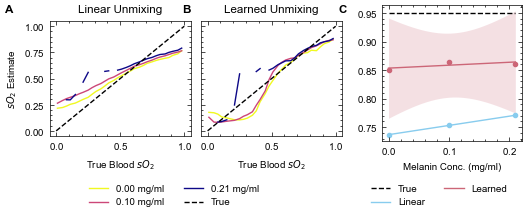

In [10]:
from palettable.cartocolors.qualitative import Safe_2

fig = plt.figure(figsize=(5.25, 5.25 / 3))
subfiga, subfigb = fig.subfigures(1, 2, width_ratios=[2, 1])
ax1, ax2 = subfiga.subplots(1, 2, sharex=True, sharey=True)
ax3 = subfigb.subplots()

bins = np.linspace(0, 1, 31) * 100
labels = ((bins[:-1] + bins[1:]) / 2).astype(np.int32)

single_ox = []

for (conc, n), gr_p in df.groupby(["melanin_index", "melanin"], sort=True):
    if n == "Base_phantom":  # Base_phantom is from a separate batch
        continue

    gr = gr_p[~np.isnan(gr_p["oxygenation"].astype(np.double))].copy()
    gr["so2_mean"] = gr["unmixed_so2"].apply(np.mean, axis=0)
    gr["SKIN_so2_mean"] = gr["SKIN_so2"].apply(np.mean, axis=0)
    gr["bin"] = pd.cut(
        x=gr["oxygenation"], bins=bins, labels=labels, include_lowest=True
    )

    so2 = (
        gr[["bin", "so2_mean", "SKIN_so2_mean"]]
        .groupby("bin")
        .apply("mean", numeric_only=True)
    )

    single_ox.append(
        {
            "melanin_index": conc,
            "so2": so2.loc[95, "so2_mean"],
            "SKIN_so2": so2.loc[95, "SKIN_so2_mean"],
        }
    )

    so2 = so2.reset_index()

    # Plot the oxygenation dependence.
    ax1.plot(
        so2["bin"].astype(np.double) / 100,
        so2["so2_mean"],
        label=f"{conc:.2f} mg/ml",
        c=colours[n],
    )
    ax2.plot(
        so2["bin"].astype(np.double) / 100,
        so2["SKIN_so2_mean"],
        label=f"{conc:.2f} mg/ml",
        c=colours[n],
    )


ax1.plot([0, 1], [0, 1], c="k", linestyle="--", label="True")
ax2.plot([0, 1], [0, 1], c="k", linestyle="--")

df_so2 = pd.DataFrame(single_ox)
ax3.plot(
    [np.min(df_so2["melanin_index"]), np.max(df["melanin_index"])],
    [0.95, 0.95],
    c="k",
    linestyle="--",
    label="True",
)

ax3.scatter(df_so2["melanin_index"], df_so2["so2"], color=Safe_2.mpl_colors[0])
# ax3.plot(df_so2["melanin_index"], df_so2["so2"], color=Safe_2.mpl_colors[0], label="Linear")

# Add line of best fit?
from patato.useful_utilities import (
    add_axis_label,
    add_subfigure_label,
    linear_regression,
)

x_eval = np.linspace(np.min(df_so2["melanin_index"]), np.max(df_so2["melanin_index"]))

res, prediction = linear_regression(
    df_so2["melanin_index"], df_so2["so2"], x_predict=x_eval
)
ax3.plot(x_eval, res.predicted_mean, color=Safe_2.mpl_colors[0], label="Linear")
ax3.fill_between(
    x_eval,
    *res.conf_int().T,
    linewidth=0,
    color=Safe_2.mpl_colors[0],
    alpha=0.2,
    zorder=-100,
)
print("P values and parameters for linear unmixing:")
print("P values:\n", prediction.pvalues)
print("Parameters:\n", prediction.params)
print("CIs:\n", prediction.conf_int())

ax3.scatter(df_so2["melanin_index"], df_so2["SKIN_so2"], color=Safe_2.mpl_colors[1])
# ax3.plot(df_so2["melanin_index"], df_so2["SKIN_so2"], color=Safe_2.mpl_colors[1], label="Learned")

res, prediction = linear_regression(
    df_so2["melanin_index"], df_so2["SKIN_so2"], x_predict=x_eval
)
ax3.plot(x_eval, res.predicted_mean, color=Safe_2.mpl_colors[1], label="Learned")
ax3.fill_between(
    x_eval,
    *res.conf_int().T,
    linewidth=0,
    color=Safe_2.mpl_colors[1],
    alpha=0.2,
    zorder=-100,
)
print("P values and parameters for learned unmixing:")
print("P values:\n", prediction.pvalues)
print("Parameters:\n", prediction.params)
print("CIs:\n", prediction.conf_int())

ax3.set_xlabel("Melanin Conc. (mg/ml)")
# ax3.set_ylabel("$sO_2$ Estimate")
subfigb.legend(frameon=False, bbox_to_anchor=(0.5, 0.0), loc="upper center", ncols=2)

subfiga.legend(
    *ax1.get_legend_handles_labels(),
    frameon=False,
    bbox_to_anchor=(0.5, 0.0),
    loc="upper center",
    ncols=2,
)
ax1.set_title("Linear Unmixing")
ax2.set_title("Learned Unmixing")
ax1.set_ylabel("$sO_2$ Estimate")
ax1.set_xlabel("True Blood $sO_2$")
ax2.set_xlabel("True Blood $sO_2$")

for ax, label, manual_x in zip([ax1, ax2, ax3], "ABC", [0, -0.15, -0.15]):
    add_axis_label(ax, label, manual_x=manual_x)

plt.savefig("../figures/so2_quantification.png", dpi=300)
plt.savefig("../figures/so2_quantification.pdf", dpi=300)
plt.show()